In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import pandas_datareader.data as web
import pandas_datareader.wb as wb
from tiingo import TiingoClient

In [5]:
key=("#######")

In [6]:
df = pdr.get_data_tiingo('AAPL',api_key=key)

In [8]:
df.to_csv('AAPL.csv')

In [9]:
df=pd.read_csv('AAPL.csv')

In [11]:
df.head(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-07-12 00:00:00+00:00,97.42,97.70,97.12,97.17,24167463,22.748880,22.814264,22.678826,22.690502,96669852,0.0,1.0
1,AAPL,2016-07-13 00:00:00+00:00,96.87,97.67,96.84,97.41,25892171,22.620448,22.807258,22.613442,22.746545,103568684,0.0,1.0
2,AAPL,2016-07-14 00:00:00+00:00,98.79,98.99,97.32,97.39,38918997,23.068794,23.115496,22.725529,22.741875,155675988,0.0,1.0
3,AAPL,2016-07-15 00:00:00+00:00,98.78,99.30,98.50,98.92,30136990,23.066458,23.187885,23.001075,23.099150,120547960,0.0,1.0
4,AAPL,2016-07-18 00:00:00+00:00,99.83,100.13,98.60,98.70,36493867,23.311648,23.381702,23.024426,23.047777,145975468,0.0,1.0


In [12]:
df2 = df.reset_index()['close']

In [17]:
df2

0        97.42
1        96.87
2        98.79
3        98.78
4        99.83
         ...  
1253    139.96
1254    142.02
1255    144.57
1256    143.24
1257    145.11
Name: close, Length: 1258, dtype: float64

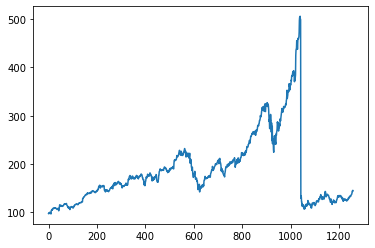

In [18]:
plt.plot(df2)

In [26]:
#for LSTM we are using MinMaxScalar
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))

In [27]:
df2

array([[0.00183186],
       [0.0004885 ],
       [0.00517806],
       ...,
       [0.11699477],
       [0.11374628],
       [0.11831371]])

In [28]:
training_size=int(len(df2)*0.65)
test_size=len(df2)-training_size
train_data,test_data=df2[0:training_size,:],df2[training_size:len(df2),:1]

In [32]:
def create_dataset(dataset,time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [33]:
time_step = 100
X_train,y_train = create_dataset(train_data,time_step)
X_test,y_test = create_dataset(test_data,time_step)

In [38]:
print(X_test.shape)

(340, 100)


In [37]:
print(X_train.shape)

(716, 100)


In [39]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [42]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 473ms/step - loss: 0.0104 - val_loss: 0.0415
Epoch 2/100
12/12 [==============================] - 3s 271ms/step - loss: 0.0024 - val_loss: 0.0258
Epoch 3/100
12/12 [==============================] - 3s 273ms/step - loss: 0.0012 - val_loss: 0.0259
Epoch 4/100
12/12 [==============================] - 3s 274ms/step - loss: 6.7954e-04 - val_loss: 0.0198
Epoch 5/100
12/12 [==============================] - 3s 275ms/step - loss: 4.5292e-04 - val_loss: 0.0194
Epoch 6/100
12/12 [==============================] - 3s 275ms/step - loss: 4.0686e-04 - val_loss: 0.0194
Epoch 7/100
12/12 [==============================] - 4s 321ms/step - loss: 3.9327e-04 - val_loss: 0.0188
Epoch 8/100
12/12 [==============================] - 4s 343ms/step - loss: 3.8702e-04 - val_loss: 0.0182
Epoch 9/100
12/12 [==============================] - 3s 284ms/step - loss: 3.7166e-04 - val_loss: 0.0178
Epoch 10/100
12/12 [==============================] - 3s 278ms/step

12/12 [==============================] - 4s 348ms/step - loss: 1.5905e-04 - val_loss: 0.0072
Epoch 79/100
12/12 [==============================] - 4s 338ms/step - loss: 1.7299e-04 - val_loss: 0.0073
Epoch 80/100
12/12 [==============================] - 4s 364ms/step - loss: 1.6412e-04 - val_loss: 0.0069
Epoch 81/100
12/12 [==============================] - 4s 355ms/step - loss: 1.3923e-04 - val_loss: 0.0069
Epoch 82/100
12/12 [==============================] - 4s 346ms/step - loss: 1.3570e-04 - val_loss: 0.0068
Epoch 83/100
12/12 [==============================] - 4s 347ms/step - loss: 1.3321e-04 - val_loss: 0.0068
Epoch 84/100
12/12 [==============================] - 4s 349ms/step - loss: 1.3734e-04 - val_loss: 0.0067
Epoch 85/100
12/12 [==============================] - 4s 366ms/step - loss: 1.3857e-04 - val_loss: 0.0070
Epoch 86/100
12/12 [==============================] - 4s 362ms/step - loss: 1.4665e-04 - val_loss: 0.0066
Epoch 87/100
12/12 [==============================] - 4s 35

In [45]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [46]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [47]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.010358238983617213

In [48]:
math.sqrt(mean_squared_error(y_test,test_predict))

0.07706641839722576

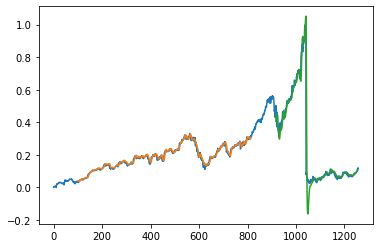

In [49]:
#shift train prediction
back = 100
trainprpl= np.empty_like(df2)
trainprpl[:,:] = np.nan
trainprpl[back:len(train_predict)+back,:] = train_predict

#shift test prediction
testprpl = np.empty_like(df2)
testprpl[:,:] = np.nan
testprpl[len(train_predict)+(back*2)+1:len(df2)-1,:]=test_predict

#plot
plt.plot(scaler.inverse_transform(df2))
plt.plot(trainprpl)
plt.plot(testprpl)
plt.show()

In [52]:
len(test_data)

441

In [54]:
#taking 100days to predict next day and so on

X_input = test_data[341:].reshape(1,-1)
X_input.shape

(1, 100)

In [55]:
#converting to list

temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [58]:
#demonstrate 10 days prediction

from numpy import array

first_op = []
n_steps = 100
i=0
while(i<30):
    if(len(temp_input)>100):
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input=X_input.reshape((1,n_steps,1))
        yhat=model.predict(X_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        first_op.extend(yhat.tolist())
        i=i+1
    else:
        X_input=X_input.reshape((1,n_steps,1))
        yhat=model.predict(X_input,verbose=0)
        temp_input.extend(yhat[0].tolist())
        first_op.extend(yhat.tolist())
        i=i+1
        
print(first_op)

0 day input [0.08069953 0.08109032 0.07163793 0.07129598 0.07005032 0.0594011
 0.06006057 0.07600997 0.06948854 0.06201456 0.05730057 0.06045137
 0.04809242 0.05963314 0.0569342  0.06177031 0.0594988  0.06672854
 0.07058766 0.06860925 0.05827756 0.05695862 0.06526306 0.06318695
 0.05720287 0.05842411 0.05993845 0.0603781  0.0567388  0.06223438
 0.06431049 0.07139368 0.07215085 0.07627864 0.08228714 0.08872307
 0.08443652 0.09222803 0.08636608 0.092399   0.09156856 0.09322945
 0.08900396 0.08995652 0.08614626 0.09195936 0.09293635 0.09213033
 0.09015192 0.08990767 0.08497387 0.08761174 0.07615651 0.07676713
 0.0807728  0.08192077 0.07371403 0.0714181  0.06374872 0.06912217
 0.07517952 0.0722974  0.06882908 0.06843828 0.07483758 0.07024571
 0.07432465 0.07383616 0.07371403 0.06987934 0.06824288 0.06743686
 0.069342   0.06562943 0.07136925 0.07139368 0.07344536 0.07439793
 0.0719066  0.07493527 0.08258024 0.08052855 0.08177422 0.08577988
 0.08253139 0.08702555 0.09112891 0.09044502 0.0897

7 day output [[0.12594655]]
8 day input [0.06948854 0.06201456 0.05730057 0.06045137 0.04809242 0.05963314
 0.0569342  0.06177031 0.0594988  0.06672854 0.07058766 0.06860925
 0.05827756 0.05695862 0.06526306 0.06318695 0.05720287 0.05842411
 0.05993845 0.0603781  0.0567388  0.06223438 0.06431049 0.07139368
 0.07215085 0.07627864 0.08228714 0.08872307 0.08443652 0.09222803
 0.08636608 0.092399   0.09156856 0.09322945 0.08900396 0.08995652
 0.08614626 0.09195936 0.09293635 0.09213033 0.09015192 0.08990767
 0.08497387 0.08761174 0.07615651 0.07676713 0.0807728  0.08192077
 0.07371403 0.0714181  0.06374872 0.06912217 0.07517952 0.0722974
 0.06882908 0.06843828 0.07483758 0.07024571 0.07432465 0.07383616
 0.07371403 0.06987934 0.06824288 0.06743686 0.069342   0.06562943
 0.07136925 0.07139368 0.07344536 0.07439793 0.0719066  0.07493527
 0.08258024 0.08052855 0.08177422 0.08577988 0.08253139 0.08702555
 0.09112891 0.09044502 0.0897367  0.08900396 0.0930829  0.09686874
 0.0984075  0.09916467 

16 day output [[0.13607904]]
17 day input [0.06672854 0.07058766 0.06860925 0.05827756 0.05695862 0.06526306
 0.06318695 0.05720287 0.05842411 0.05993845 0.0603781  0.0567388
 0.06223438 0.06431049 0.07139368 0.07215085 0.07627864 0.08228714
 0.08872307 0.08443652 0.09222803 0.08636608 0.092399   0.09156856
 0.09322945 0.08900396 0.08995652 0.08614626 0.09195936 0.09293635
 0.09213033 0.09015192 0.08990767 0.08497387 0.08761174 0.07615651
 0.07676713 0.0807728  0.08192077 0.07371403 0.0714181  0.06374872
 0.06912217 0.07517952 0.0722974  0.06882908 0.06843828 0.07483758
 0.07024571 0.07432465 0.07383616 0.07371403 0.06987934 0.06824288
 0.06743686 0.069342   0.06562943 0.07136925 0.07139368 0.07344536
 0.07439793 0.0719066  0.07493527 0.08258024 0.08052855 0.08177422
 0.08577988 0.08253139 0.08702555 0.09112891 0.09044502 0.0897367
 0.08900396 0.0930829  0.09686874 0.0984075  0.09916467 0.10573494
 0.11076645 0.11699477 0.11374628 0.11831371 0.11463105 0.11733688
 0.11926384 0.1206909 

24 day output [[0.1456802]]
25 day input [0.05842411 0.05993845 0.0603781  0.0567388  0.06223438 0.06431049
 0.07139368 0.07215085 0.07627864 0.08228714 0.08872307 0.08443652
 0.09222803 0.08636608 0.092399   0.09156856 0.09322945 0.08900396
 0.08995652 0.08614626 0.09195936 0.09293635 0.09213033 0.09015192
 0.08990767 0.08497387 0.08761174 0.07615651 0.07676713 0.0807728
 0.08192077 0.07371403 0.0714181  0.06374872 0.06912217 0.07517952
 0.0722974  0.06882908 0.06843828 0.07483758 0.07024571 0.07432465
 0.07383616 0.07371403 0.06987934 0.06824288 0.06743686 0.069342
 0.06562943 0.07136925 0.07139368 0.07344536 0.07439793 0.0719066
 0.07493527 0.08258024 0.08052855 0.08177422 0.08577988 0.08253139
 0.08702555 0.09112891 0.09044502 0.0897367  0.08900396 0.0930829
 0.09686874 0.0984075  0.09916467 0.10573494 0.11076645 0.11699477
 0.11374628 0.11831371 0.11463105 0.11733688 0.11926384 0.1206909
 0.12185409 0.1229019  0.12391269 0.12492259 0.12594655 0.12699044
 0.12805644 0.12914525 0.13

In [64]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [65]:
df3=df2.tolist()
df3.extend(first_op)

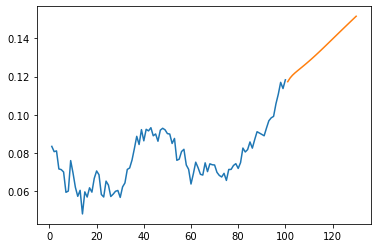

In [66]:
plt.plot(day_new,scaler.inverse_transform(df2[1158:]))
plt.plot(day_pred,scaler.inverse_transform(first_op))

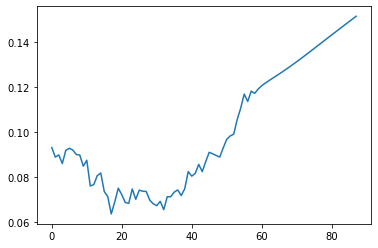

In [68]:
df3=df2.tolist()
df3.extend(first_op)
plt.plot(df3[1200:])